In [1]:
import numpy as np
import cv2     
import math   
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd
from tensorflow.keras.preprocessing import image 
from keras.utils import np_utils
from skimage.transform import resize
import os
from PIL import Image
import tensorflow as tf

Using TensorFlow backend.


In [2]:
# 약 8만장의 train set이 0, 1 클래스로 분류된 csv 파일 읽기

train_image_data = pd.read_csv('mapping_train_image.csv')     # reading the csv file
train_image_data.head()      # printing first five rows of the file

,Image_ID,Class
0,20200214_GRF_APK_3_train_image_0000.jpg,0
1,20200214_GRF_APK_3_train_image_0001.jpg,0
2,20200214_GRF_APK_3_train_image_0002.jpg,0
3,20200214_GRF_APK_3_train_image_0003.jpg,0
4,20200214_GRF_APK_3_train_image_0004.jpg,0


In [3]:
# train 이미지 데이터 전처리

X = [ ]     # creating an empty array
for img_name in train_image_data.Image_ID:
    img = plt.imread('' + './train_image/'+img_name)
    X.append(img)  # storing each image in array X
X = np.array(X)    # converting list to array

image = []
for i in range(0,X.shape[0]):
    a = resize(X[i], preserve_range=True, output_shape=(100,100)).astype(int)     # reshaping to 100*100*3
    image.append(a)
X = np.array(image)

from keras.applications.xception import preprocess_input
X_train = preprocess_input(X)      # preprocessing the input data

y = train_image_data.Class
y_train = np_utils.to_categorical(y)    # one hot encoding Classes

In [4]:
# 약 1만장의 val set이 0, 1 클래스로 분류된 csv 파일 읽기

val_image_data = pd.read_csv('mapping_val_image.csv')     # reading the csv file
val_image_data.head()      # printing first five rows of the file

,Image_ID,Class
0,20200216_T1_GEN_1_val_image_0000.jpg,0
1,20200216_T1_GEN_1_val_image_0001.jpg,0
2,20200216_T1_GEN_1_val_image_0002.jpg,0
3,20200216_T1_GEN_1_val_image_0003.jpg,0
4,20200216_T1_GEN_1_val_image_0004.jpg,0


In [5]:
# val 이미지 데이터 전처리

X = [ ]     # creating an empty array
for img_name in val_image_data.Image_ID:
    img = plt.imread('' + './val_image/'+img_name)
    X.append(img)  # storing each image in array X
X = np.array(X)    # converting list to array

image = []
for i in range(0,X.shape[0]):
    a = resize(X[i], preserve_range=True, output_shape=(100,100)).astype(int)      # reshaping to 100*100*3
    image.append(a)
X = np.array(image)

from keras.applications.xception import preprocess_input
X_valid = preprocess_input(X)      # preprocessing the input data

y = val_image_data.Class
y_val = np_utils.to_categorical(y)    # one hot encoding Classes

In [6]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Input, concatenate

In [7]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(100, 100, 3))    # include_top=False to remove the top layer

X_train = base_model.predict(X_train)
X_valid = base_model.predict(X_valid)

print(X_train.shape, X_valid.shape)

(54753, 3, 3, 2048) (9395, 3, 3, 2048)


In [8]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]*X_train.shape[3]) # converting to 1-D 
X_valid = X_valid.reshape(X_valid.shape[0], X_valid.shape[1]*X_valid.shape[2]*X_valid.shape[3])

X_train = X_train/X_train.max()      # centering the data
X_valid = X_valid/X_train.max()

In [9]:
# i. Building the model
model = Sequential()
model.add(InputLayer(3*3*2048,))    # input layer
model.add(Dense(1024, activation='relu')) # hidden layer
model.add(Dense(512, activation='relu')) # hidden layer
model.add(Dense(64, activation='relu')) # hidden layer
model.add(Dense(2, activation='softmax'))    # output layer

model.summary()

# ii. Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy',tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')])

# iii. Training the model
history = model.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_valid, y_val), verbose=2)

# 모델과 가중치 저장
from keras.models import load_model
model.save('highlight_finder.h5')
model.save_weights('highlight_finder_weight.h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              18875392  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 19,433,154
Trainable params: 19,433,154
Non-trainable params: 0
_________________________________________________________________
Train on 54753 samples, validate on 9395 samples
Epoch 1/10
54753/54753 - 7s - loss: 0.3435 - accuracy: 0.8479 - precision: 0.8479 - recall: 0.8479 - val_loss: 2.9967 - val_accuracy: 0.8133 - val_precision: 0.8133 - val_recall: 0.8133
Epoch 2

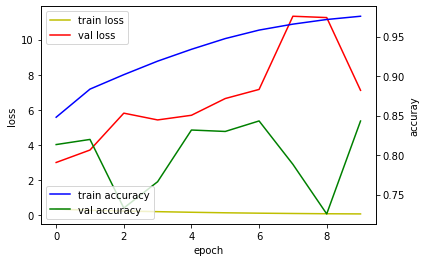

In [10]:
# 학습과정 살펴보기

#print(history.history['loss'])
#print(history.history['accuracy'])
#print(history.history['val_loss'])
#print(history.history['val_accuracy'])

%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# 테스트 데이터에 대한 predict

In [27]:
# 이미 mapping_test_image2.csv에 Image_ID가 적혀진 경우 이 셀 실행 X
# 폴더에 존재하는 이미지 파일들의 이름을 Image_ID로 적어주는 코드

csv = pd.read_csv('mapping_image.csv') # Image_ID와 Class가 두 개의 빈 column으로 존재하는 csv 파일

_list = list(os.listdir('test_image'))

csv['Image_ID'] = _list

csv.to_csv('mapping_test_image.csv', index=False)

In [11]:
test = pd.read_csv('mapping_test_image.csv')

test_image = []
for img_name in test.Image_ID:
    img = plt.imread('' + './test_image2/'+img_name)
    test_image.append(img)
test_img = np.array(test_image)

test_image = []
for i in range(0,test_img.shape[0]):
    a = resize(test_img[i], preserve_range=True, output_shape=(100,100)).astype(int)
    test_image.append(a)
test_image = np.array(test_image)

# preprocessing the images
test_image = preprocess_input(test_image)

# extracting features from the images using pretrained model
test_image = base_model.predict(test_image)

# converting the images to 1-D form
test_image = test_image.reshape(7680, 3*3*2048) # 7680 = 테스트 이미지 수, 3*3*2048: 베이스 모델 통과한 결과값

# zero centered images
test_image = test_image/test_image.max()

# make prediction
predictions_class = model.predict_classes(test_image)
predictions_prob = model.predict(test_image)

In [12]:
print("The screen time of non highlight is", (predictions_class[predictions_class==0].shape[0])/2, "seconds")
print("The screen time of highlight is", (predictions_class[predictions_class==1].shape[0])/2, "seconds")

The screen time of non highlight is 3424.5 seconds
The screen time of highlight is 415.5 seconds


In [13]:
print(list(predictions_class))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [14]:
# 0, 1클래스를 추가해서 새로 csv 파일 만듦

csv = pd.read_csv('mapping_test_image2.csv') # test 이미지 파일명이 담긴 csv파일

csv['Class'] = predictions_class # predictions_class은 np.array 형태
    
csv.to_csv('test_result.csv', index=False)

In [15]:
result = pd.read_csv('test_result.csv')

num = 0
for i in range(len(result['Class'])):
    if result['Class'][i] == result['Real_Class'][i]:
        num += 1
        
print('HL인 부분과 HL이 아닌 부분을 동시에 맞췄을 확률:', num/len(result['Class']))

k = 0
for i in range(len(result['Class'])):
    if result['Class'][i] == 1 and result['Real_Class'][i] == 1:
        k += 1
        
print('실제로 HL인 부분중 HL이라고 예측했을 확률:', k/sum(result['Real_Class']))

HL인 부분과 HL이 아닌 부분을 동시에 맞췄을 확률: 0.88125
실제로 HL인 부분중 HL이라고 예측했을 확률: 0.4518430439952438


절대적, 수치적으로 보자면 HL을 44%만 맞췄다고 할 수 있지만, 주관적, 상대적으로 봤을땐 '저정도도 하이라이트다'라고 생각할만한 구간을 잡음